<a href="https://colab.research.google.com/github/andresperez86/EntregasDL/blob/master/07_Prediction_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparing data: Run the next cells to download and prepare the datasets and util functions.

In [0]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [0]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann-predict-future-sales/master/init.py
    from init import download_utils, unzip_sales_dataset, dataset_dir
    download_utils(force_download=True)

In [0]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo" -O local/datasets/sales.zip && rm -rf /tmp/cookies.txt

--2020-06-09 04:26:09--  https://docs.google.com/uc?export=download&confirm=&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo
Resolving docs.google.com (docs.google.com)... 74.125.26.139, 74.125.26.100, 74.125.26.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.26.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-78-docs.googleusercontent.com/docs/securesc/ilphhk9ikhqhfnfh9nlog1vvfgds49k7/fg6pud02noi0899r56em8m7q7tqb0v0b/1591676700000/02012202667471862451/09471193954765413464Z/19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo?e=download [following]
--2020-06-09 04:26:09--  https://doc-10-78-docs.googleusercontent.com/docs/securesc/ilphhk9ikhqhfnfh9nlog1vvfgds49k7/fg6pud02noi0899r56em8m7q7tqb0v0b/1591676700000/02012202667471862451/09471193954765413464Z/19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo?e=download
Resolving doc-10-78-docs.googleusercontent.com (doc-10-78-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connecting to doc-1

In [0]:
if download_data:
    unzip_sales_dataset()

In [0]:
ruta_zip='./competitive-data-science-predict-future-sales.zip'
dataset_dir = "./local/datasets/"
password = None

In [0]:

import zipfile

archivo_zip = zipfile.ZipFile(ruta_zip, "r")
try:
    print(archivo_zip.namelist())
    archivo_zip.extractall(pwd=password, path=dataset_dir)

except:
    pass
archivo_zip.close()

['item_categories.csv', 'items.csv', 'sales_train.csv', 'sample_submission.csv', 'shops.csv', 'test.csv']


Import Libraries

In [0]:
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv('./local/datasets/sales_train.csv')

In [0]:
item_category = pd.read_csv('./local/datasets/item_categories.csv')

In [0]:
items  = pd.read_csv('./local/datasets/items.csv')

In [0]:
test = pd.read_csv('./local/datasets/to_predict.csv')

In [0]:
test = pd.read_csv('./local/datasets/test.csv')

In [0]:
dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


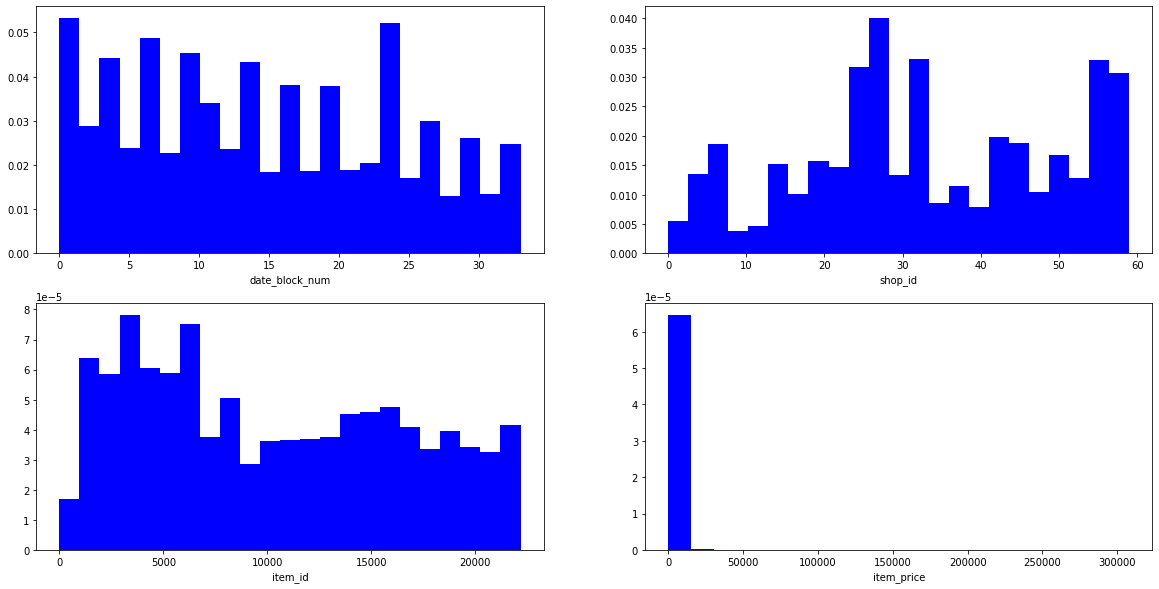

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharey=False)
axs[0,0].hist(train['date_block_num'], bins='sturges', density=True, facecolor='blue')
axs[0,0].set_xlabel('date_block_num')
axs[0,1].hist(train['shop_id'], bins='sturges', density=True, facecolor='blue')
axs[0,1].set_xlabel('shop_id')
axs[1,0].hist(train['item_id'], bins='sturges', density=True, facecolor='blue')
axs[1,0].set_xlabel('item_id')
axs[1,1].hist(train['item_price'], bins=20, density=True, facecolor='blue')
axs[1,1].set_xlabel('item_price')
plt.show()

In [0]:
def drop_duplicate(data, subset):
    print('Before drop shape:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True) #subset is list where you have to put all column for duplicate check
    data.reset_index(drop=True, inplace=True)
    print('After drop shape:', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)

In [0]:
def unresanable_data(data):
    print("Min Value:",data.min())
    print("Max Value:",data.max())
    print("Average Value:",data.mean())
    print("Center Point of Data:",data.median())

In [0]:
# -1 and 307980 looks like outliers, let's delete them
print('before train shape:', dataset.shape)
dataset = dataset[(dataset.item_price > 0) & (dataset.item_price < 300000)]
print('after train shape:', dataset.shape)

before train shape: (2935849, 6)
after train shape: (2935847, 6)


In [0]:
# Drop Duplicate Data
subset = ['date', 'shop_id', 'item_id','item_cnt_day']
drop_duplicate(dataset, subset=subset)

Before drop shape: (2935847, 6)
After drop shape: (2935823, 6)
Total Duplicate: 24


In [0]:
import seaborn as sns

In [0]:
def plot_comparison(x, title):
    fig, ax = plt.subplots(3, 1, figsize=(9, 7), sharex=True,)
    sns.distplot(x, ax=ax[0], color='#1f77b5', hist_kws=dict(alpha=1), kde_kws=dict(color='k'))
    #ax[0].set_title('Histogram and kernel density estimate')
    sns.boxplot(x, ax=ax[1])
    #ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2])
    #ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=16)
    plt.show()

In [0]:
sales=dataset.groupby('date_block_num').sum()['item_cnt_day']


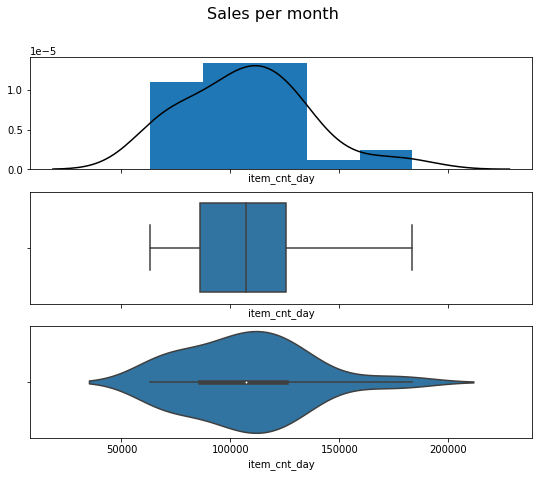

In [0]:
plot_comparison(sales,'Sales per month' )

#Distribution Checking

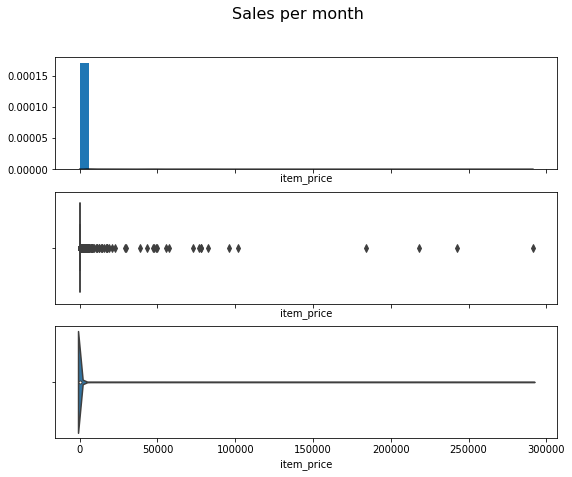

In [0]:
plot_comparison(dataset.item_price.value_counts().sort_index(ascending=False),'Sales per month' )

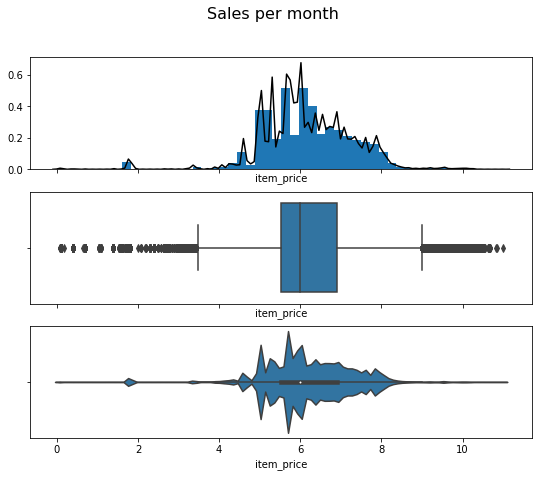

In [0]:
plot_comparison(dataset.item_price.map(np.log1p),'Sales per month' )

In [0]:
print('before train shape:', dataset.shape)
train = dataset[(dataset.item_price > 0) & (dataset.item_price < 300000)]
print('after train shape:', train.shape)


before train shape: (2935823, 6)
after train shape: (2935823, 6)


In [0]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,6.907755,1.0
1,03.01.2013,0,25,2552,6.802395,1.0
2,05.01.2013,0,25,2552,6.802395,-1.0
3,06.01.2013,0,25,2554,7.444278,1.0
4,15.01.2013,0,25,2555,7.003065,1.0


Text(0.5, 0, 'Price')

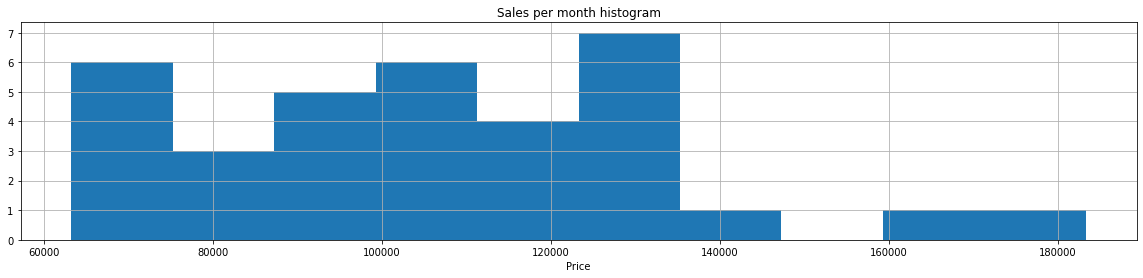

In [0]:
train.groupby('date_block_num').sum()['item_cnt_day'].hist(figsize = (20,4), bins=10)
plt.title('Sales per month histogram')
plt.xlabel('Price')

Text(0.5, 1.0, 'Original Distiribution')

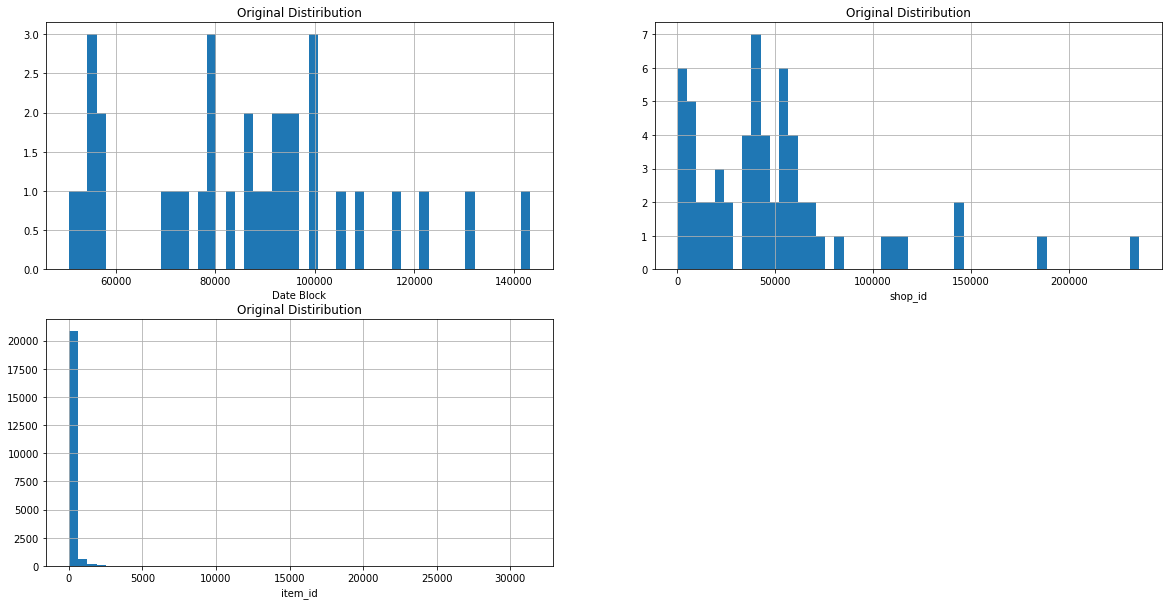

In [0]:
# unresanable_data(train['date_block_num'])
count_price = train.date_block_num.value_counts().sort_index(ascending=False)
plt.subplot(221)
count_price.hist(figsize=(20,10), bins=50)
plt.xlabel('Date Block');
plt.title('Original Distiribution')

count_price = train.shop_id.value_counts().sort_index(ascending=False)
plt.subplot(222)
count_price.hist(figsize=(20,10), bins=50)
plt.xlabel('shop_id');
plt.title('Original Distiribution')

count_price = train.item_id.value_counts().sort_index(ascending=False)
plt.subplot(223)
count_price.hist(figsize=(20,10), bins=50)
plt.xlabel('item_id');
plt.title('Original Distiribution')

In [0]:
l = list(item_category.item_category_name)
l_cat = l

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'


item_category['cats'] = l_cat
item_category.head()

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


Convert Date Column data type from object to Date

In [0]:
train['date'] = pd.to_datetime(train.date,format="%d.%m.%Y")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,6.907755,1.0
1,2013-01-03,0,25,2552,6.802395,1.0
2,2013-01-05,0,25,2552,6.802395,-1.0
3,2013-01-06,0,25,2554,7.444278,1.0
4,2013-01-15,0,25,2555,7.003065,1.0


In [0]:
## Pivot by monht to wide format
p_df = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()

date_block_num    0     1    2    3    4    5   ...   28   29   30   31   32   33
shop_id item_id                                 ...                              
0       30       0.0  31.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
        31       0.0  11.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
        32       6.0  10.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
        33       3.0   3.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
        35       1.0  14.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 34 columns]

In [0]:
## Join with categories
train_cleaned_df = p_df.reset_index()
train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')

item_to_cat_df = items.merge(item_category[['item_category_id','cats']], how="inner", on="item_category_id")[['item_id','cats']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

# Encode Categories
from sklearn import preprocessing

number = preprocessing.LabelEncoder()
train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)
train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats'] + list(range(34))]
train_cleaned_df.head()

,shop_id,item_id,cats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,30,7,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,7,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
import xgboost as xgb
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

1.2689500930744357


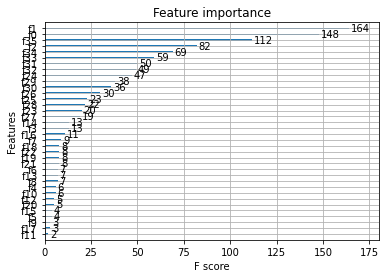

In [0]:
xgb.plot_importance(bst)

In [0]:
apply_df = test
apply_df['shop_id']= apply_df.shop_id.astype('str')
apply_df['item_id']= apply_df.item_id.astype('str')

apply_df = test.merge(train_cleaned_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
apply_df.head()

,ID,shop_id,item_id,cats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Move to one month front
d = dict(zip(apply_df.columns[4:],list(np.array(list(apply_df.columns[4:])) - 1)))

apply_df  = apply_df.rename(d, axis = 1)

In [0]:
preds = bst.predict(xgb.DMatrix(apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != -1)].values))

In [0]:
# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':apply_df.ID,'item_cnt_month': preds })
sub_df.describe()


,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.293469
std,61834.358168,0.686292
min,0.000000,0.000000
25%,53549.750000,0.138123
50%,107099.500000,0.177903
75%,160649.250000,0.279623
max,214199.000000,20.000000
